##DISTIL_BERT

In [ ]:
!pip install transformers
!pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import nltk
import re
import numpy as np
from wordcloud import STOPWORDS
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import torch
import transformers

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,precision_score,accuracy_score,f1_score
from sklearn.metrics import precision_recall_fscore_support

from transformers import DistilBertTokenizer, Trainer, DistilBertForSequenceClassification, TrainingArguments, DistilBertTokenizerFast

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Загрузка модели и токенизатора, предварительно обученных на русском языке
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-multilingual-cased", num_labels=3)
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-multilingual-cased")


config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [ ]:
# Инициализация девайса
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# Загрузка данных
df = pd.read_csv('/content/news_2014_2023_scored.csv')

In [ ]:
# Добавление признака 'label'
from sklearn.utils import resample
sent = df.Sentiment.unique()
index = [i for i in range(len(sent.tolist()))]
label = dict(zip(sent, index))

sent = list(sent)
df['label'] = df.Sentiment.replace(label)
df.head()

,Link,Date,Title,Score,Sentiment,label
0,https://www.finam.ru/publications/item/dve-tre...,2014-01-01,Две трети россиян не имеют вкладов в банках,-0.443525,отрицательный,0
1,https://www.finam.ru/publications/item/inflyac...,2014-01-01,"Инфляция в РФ в 2013 году, по предварительным ...",0.099238,нейтральный,1
2,https://www.finam.ru/publications/item/rossiya...,2014-01-01,"Россия начинает председательство в G8, главная...",0.470865,положительный,2
3,https://www.finam.ru/publications/item/putin-o...,2014-01-01,Путин обещает продолжить борьбу с террористами...,-0.034546,нейтральный,1
4,https://www.finam.ru/publications/item/kapital...,2014-01-01,Капитала много не бывает! Сохраняйте и приумно...,-0.121388,нейтральный,1


In [ ]:
# Общая информация о количестве записей и удаление дубликатов
df.info()
print('Общее количество записей в файле: ', df.shape[0])
df.drop_duplicates(inplace=True)
print('Общее количество записей после удаления дубликатов: ', df.shape[0])
print('Пропущенные значения: ', df['label'].isnull().sum())
df.reset_index(inplace=True, drop=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302019 entries, 0 to 302018
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Link       302019 non-null  object 
 1   Date       302019 non-null  object 
 2   Title      302019 non-null  object 
 3   Score      302019 non-null  float64
 4   Sentiment  302019 non-null  object 
 5   label      302019 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 13.8+ MB
Общее количество записей в файле:  302019
Общее количество записей после удаления дубликатов:  273993
Пропущенные значения:  0


In [ ]:
# Оставляем только нужные для обучения модели колонки
df = df[['Title', 'Sentiment', 'label']]

# Проверка результата
print(df.head())


                                               Title      Sentiment  label
0        Две трети россиян не имеют вкладов в банках  отрицательный      0
1  Инфляция в РФ в 2013 году, по предварительным ...    нейтральный      1
2  Россия начинает председательство в G8, главная...  положительный      2
3  Путин обещает продолжить борьбу с террористами...    нейтральный      1
4  Капитала много не бывает! Сохраняйте и приумно...    нейтральный      1


In [ ]:
# Лемматизация
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def cleaning_data(text):

  """Функция очищает текстовые данные и приводит их в нижний регистр"""

  text = str(text).lower()
  text = text.replace('{html}', "")
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', text)
  rem_url=re.sub(r'http\S+', '',cleantext)
  rem_num = re.sub('[0-9]+', '', rem_url)
  tokenizer = RegexpTokenizer(r'\w+')
  tokens = tokenizer.tokenize(rem_num)
  filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('russian')]
  stem_words=[stemmer.stem(w) for w in filtered_words]
  lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
  return " ".join(filtered_words)
df['Title']=df['Title'].map(lambda s:cleaning_data(s))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
def ngrams(input, n):
    """ input : Предложение и количество n-граммов
  output: в n-граммах
  N-граммы - это непрерывная последовательность из n элементов из заданного образца текста.
  """
    output = []
    for i in range(len(input)-n+1):
        output.append('_'.join(input[i:i+n]))
    return output

In [ ]:
nltk.download('punkt')
tags = ['отрицательный','нейтральный','положительный']

df = df[df.Sentiment.isin(tags)]
# Применение функции ngrams и создание униграмм, биграмм и триграмм
df['Tokens'] = df.apply(lambda row: nltk.word_tokenize(row['Title'].strip()), axis=1)
df['bi_Grams']  = df.apply(lambda row: ngrams(row['Tokens'], 2), axis=1)
df['tri_Grams']  = df.apply(lambda row: ngrams(row['Tokens'], 3), axis=1)
print(len(df),'образца из',len(tags),'классов')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


273993 образца из 3 классов


In [ ]:
c_unique = Counter()
for ind in df.index:
    c_unique.update(Counter(set(df.loc[ind]['Tokens'])))

print('20 самых часто встречающихся слов:\n')
for word in c_unique.most_common(20):
    print(word[0],'-->', 'в',word[1],'новостях из {}, что составляет'.format(len(df)),np.round(100*word[1]/len(df),2),'%')

20 самых часто встречающихся слов:

сша --> в 31101 новостях из 273993, что составляет 11.35 %
индекс --> в 22676 новостях из 273993, что составляет 8.28 %
млрд --> в 16784 новостях из 273993, что составляет 6.13 %
ожидалось --> в 14813 новостях из 273993, что составляет 5.41 %
года --> в 12055 новостях из 273993, что составляет 4.4 %
рублей --> в 11732 новостях из 273993, что составляет 4.28 %
рынок --> в 11616 новостях из 273993, что составляет 4.24 %
россии --> в 10434 новостях из 273993, что составляет 3.81 %
пунктов --> в 9949 новостях из 273993, что составляет 3.63 %
нефть --> в 9641 новостях из 273993, что составляет 3.52 %
прибыль --> в 9127 новостях из 273993, что составляет 3.33 %
цен --> в 8284 новостях из 273993, что составляет 3.02 %
акции --> в 8203 новостях из 273993, что составляет 2.99 %
году --> в 7565 новостях из 273993, что составляет 2.76 %
акций --> в 7461 новостях из 273993, что составляет 2.72 %
нефти --> в 7455 новостях из 273993, что составляет 2.72 %
рынке --

In [ ]:
df_temp, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Sentiment'])
df_train, df_val = train_test_split(df_temp, test_size=0.1, random_state=42, stratify=df_temp['Sentiment'])

print("Размер обучающей выборки: " + str(df_train.shape[0]))
print("Размер валидационной выборки: " + str(df_val.shape[0]))
print("Размер тестовой выборки: " + str(df_test.shape[0]))

Размер обучающей выборки: 197274
Размер валидационной выборки: 21920
Размер тестовой выборки: 54799


In [ ]:
sentiment = df.Sentiment.unique()
maximum = 2
target_majority = df[df.Sentiment==sentiment[maximum]]

# Инициализация пустого датафрейма для собранной увеличенной выборки
train_upsampled = pd.DataFrame()

for cl in range(3):
    # Выборка миноритарного класса из обучающего набора
    train_minority = df_train[df_train.Sentiment==sentiment[cl]]
    # Увеличение выборки до размера мажоритарного класса
    train_minority_upsampled = resample(train_minority,
                                        replace=True,
                                        n_samples=len(target_majority),
                                        random_state=33)
    # Объединение увеличенной выборки с предыдущими
    train_upsampled = pd.concat([train_upsampled, train_minority_upsampled])

# Проверка баланса классов
train_upsampled['Sentiment'].value_counts()

,count
Sentiment,
отрицательный,106006
нейтральный,106006
положительный,106006


<Axes: xlabel='Sentiment', ylabel='count'>

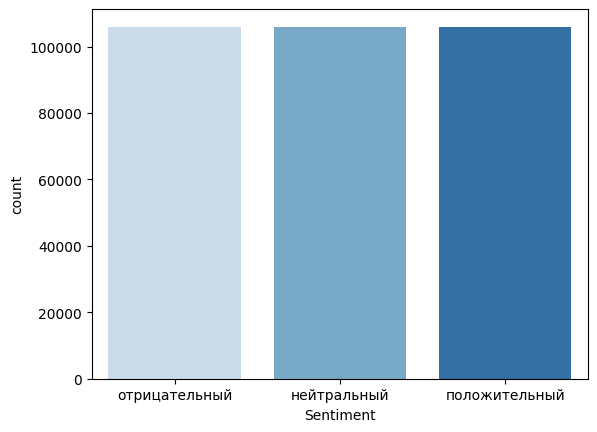

In [ ]:
sns.countplot(x="Sentiment", data=train_upsampled, palette='Blues')

<Axes: xlabel='Sentiment', ylabel='count'>

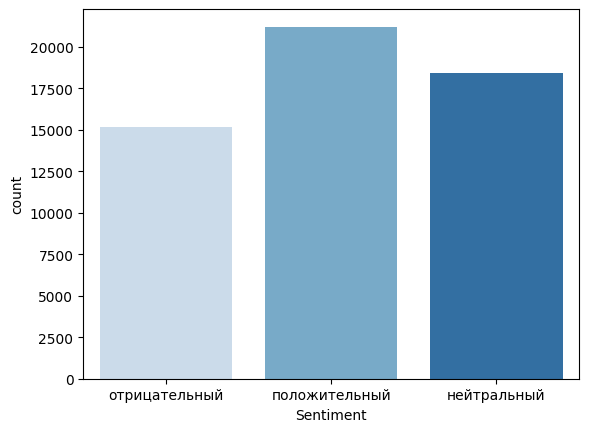

In [ ]:
sns.countplot(x="Sentiment", data=df_test, palette='Blues')

In [ ]:
import datasets
from datasets import Dataset
dataset_train = Dataset.from_pandas(train_upsampled)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

# Токенизация и форматирование датасетов
def tokenize_function(example):
    return tokenizer(example['Title'], truncation=True, padding='max_length', max_length=186)

dataset_train = dataset_train.map(tokenize_function, batched=True)
dataset_val = dataset_val.map(tokenize_function, batched=True)
dataset_test = dataset_test.map(tokenize_function, batched=True)

# Установка формата датасетов для PyTorch
dataset_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/318018 [00:00<?, ? examples/s]

Map:   0%|          | 0/21920 [00:00<?, ? examples/s]

Map:   0%|          | 0/54799 [00:00<?, ? examples/s]

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # Для мультиклассовой классификации используем 'macro'
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
from accelerate import Accelerator
from transformers import Trainer, TrainingArguments

# Инициализация Accelerator
accelerator = Accelerator()

# Определение параметров обучения
training_args = TrainingArguments(
    output_dir='/content/bert_output',      # выходная директория для сохранения результатов
    num_train_epochs=3,              # количество эпох обучения
    per_device_train_batch_size=64,  # размер батча для обучения
    per_device_eval_batch_size=64,   # размер батча для валидации
    warmup_steps=500,                # количество шагов для разогрева
    weight_decay=0.1,                # вес уменьшения
    logging_dir='/content/bert_logs',# директория для логирования
    logging_steps=500,               # шаг логирования
    learning_rate=2e-5,              # начальная скорость обучения
    evaluation_strategy="epoch",
    save_strategy="epoch",
    remove_unused_columns=True,
    load_best_model_at_end=True,      # сохранение параметров лучшей модели
    metric_for_best_model="accuracy", # метрика для оценки лучшей модели
    greater_is_better=True
)

# Инициализация Trainer
trainer = Trainer(
    model=model,                         # модель, которую мы хотим обучить
    args=training_args,                  # аргументы обучения, которые мы определили выше
    train_dataset=dataset_train,         # обучающий набор данных
    eval_dataset=dataset_val,            # набор данных для валидации
    compute_metrics=compute_metrics,     # функция для вычисления метрик
)

# Подготовка модели и датасетов
model, dataset_train = accelerator.prepare(model, dataset_train)
dataset_val = accelerator.prepare(dataset_val)

# Начало обучения
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.311500,0.356876,0.859535,0.859576,0.858911,0.860380
2,0.209000,0.386068,0.861223,0.860148,0.858130,0.863624


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.311500,0.356876,0.859535,0.859576,0.858911,0.860380
2,0.209000,0.386068,0.861223,0.860148,0.858130,0.863624
3,0.151600,0.403668,0.869069,0.868134,0.867006,0.869827


TrainOutput(global_step=14910, training_loss=0.2697694815540378, metrics={'train_runtime': 3538.6627, 'train_samples_per_second': 269.609, 'train_steps_per_second': 4.213, 'total_flos': 4.591268515902809e+16, 'train_loss': 0.2697694815540378, 'epoch': 3.0})

In [ ]:
model.eval()
predictions = trainer.predict(dataset_test).metrics
predictions

{'test_loss': 0.4140683710575104,
 'test_accuracy': 0.8648515483859195,
 'test_f1': 0.8640658301436339,
 'test_precision': 0.8632348236667226,
 'test_recall': 0.8653230840764431,
 'test_runtime': 64.5117,
 'test_samples_per_second': 849.443,
 'test_steps_per_second': 13.284}

In [ ]:
# Получение предсказаний
metrics = trainer.predict(dataset_test)

# Извлечение предсказаний
predictions = metrics.predictions  # массив предсказаний

# Преобразование в тензор и применение softmax
probs = torch.from_numpy(predictions).softmax(dim=1)

# Преобразование тензоров в numpy array
predictions = probs.numpy()

# Создание нового DataFrame с предсказаниями
new_df = pd.DataFrame(predictions, columns=df.Sentiment.unique())

# Вывод случайных 5 строк DataFrame
new_df.sample(5)


,отрицательный,нейтральный,положительный
45089,0.111308,0.888074,0.000618
53593,0.000192,0.998969,0.000839
24620,0.999460,0.000521,0.000020
5266,0.000274,0.583627,0.416099
47033,0.003336,0.337235,0.659429


In [ ]:
# Создание копии набора данных с предсказанными метками классов

df_test_bert = df_test.copy()
results = np.argmax(predictions,axis=1)
df_test_bert['pred_label'] = results

df_test_bert.sample(10)

,Title,Sentiment,label,Tokens,bi_Grams,tri_Grams,pred_label
258735,основания роста российского рынка всё ещё оста...,нейтральный,1,"[основания, роста, российского, рынка, всё, ещ...","[основания_роста, роста_российского, российско...","[основания_роста_российского, роста_российског...",1
200353,рынки вечер сменили вектор активного роста уме...,отрицательный,0,"[рынки, вечер, сменили, вектор, активного, рос...","[рынки_вечер, вечер_сменили, сменили_вектор, в...","[рынки_вечер_сменили, вечер_сменили_вектор, см...",0
51584,китайский рынок отскакивает,положительный,2,"[китайский, рынок, отскакивает]","[китайский_рынок, рынок_отскакивает]",[китайский_рынок_отскакивает],1
273054,рынках прежнему нервно,отрицательный,0,"[рынках, прежнему, нервно]","[рынках_прежнему, прежнему_нервно]",[рынках_прежнему_нервно],0
148563,италия индекс деловой активности промышленност...,нейтральный,1,"[италия, индекс, деловой, активности, промышле...","[италия_индекс, индекс_деловой, деловой_активн...","[италия_индекс_деловой, индекс_деловой_активно...",1
108251,великобритания розничные продажи февраль ожида...,положительный,2,"[великобритания, розничные, продажи, февраль, ...","[великобритания_розничные, розничные_продажи, ...","[великобритания_розничные_продажи, розничные_п...",1
254254,сбер стал миноритарным участником группы компа...,нейтральный,1,"[сбер, стал, миноритарным, участником, группы,...","[сбер_стал, стал_миноритарным, миноритарным_уч...","[сбер_стал_миноритарным, стал_миноритарным_уча...",2
127087,российский рынок добирает потенциал роста,положительный,2,"[российский, рынок, добирает, потенциал, роста]","[российский_рынок, рынок_добирает, добирает_по...","[российский_рынок_добирает, рынок_добирает_пот...",2
190949,компания rivian привлекла дополнительные млрд ...,положительный,2,"[компания, rivian, привлекла, дополнительные, ...","[компания_rivian, rivian_привлекла, привлекла_...","[компания_rivian_привлекла, rivian_привлекла_д...",2
119983,июне китай стал крупнейшим кредитором сша,нейтральный,1,"[июне, китай, стал, крупнейшим, кредитором, сша]","[июне_китай, китай_стал, стал_крупнейшим, круп...","[июне_китай_стал, китай_стал_крупнейшим, стал_...",2


In [ ]:
predictions = trainer.predict(dataset_test)

# Получение истинных меток
true_labels = dataset_test['label']
pred_labels = results
report = classification_report(true_labels, pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.91      0.89     15156
           1       0.82      0.78      0.80     18441
           2       0.89      0.91      0.90     21202

    accuracy                           0.86     54799
   macro avg       0.86      0.87      0.86     54799
weighted avg       0.86      0.86      0.86     54799



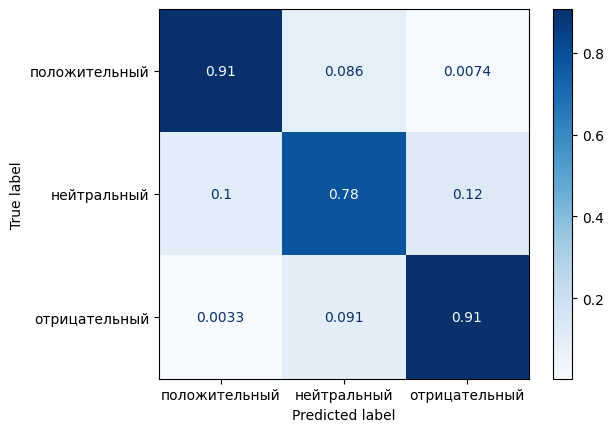

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Получение истинных меток
true_labels = dataset_test['label']
pred_labels = predictions.predictions.argmax(axis=1)

# Построение нормализованной матрицы ошибок
cm = confusion_matrix(true_labels, pred_labels, normalize='true')  # Нормализация по строкам

# Предположим, что у вас есть список меток
label_list = ['положительный', 'нейтральный', 'отрицательный']

# Отображение нормализованной матрицы ошибок
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)
disp.plot(cmap=plt.cm.Blues)
plt.show()


Точность на тестовом наборе данных после дообучения на корпусе новостей с 2014 по 2023 г. -  87%, что составило +5% к эффективности модели по accuracy и f1-мере.

#**RUBERT**

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "DeepPavlov/rubert-base-cased-sentence", num_labels=3)
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/711M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-sentence and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
import pandas as pd
df = pd.read_csv('/content/news_2014_2023_scored.csv')
df.columns = ['Date','Link','Title', 'Score', 'Sentiment']

In [ ]:
from sklearn.utils import resample
sent = df.Sentiment.unique()
index = [i for i in range(len(sent.tolist()))]
label = dict(zip(sent, index))

sent = list(sent)
df['label'] = df.Sentiment.replace(label)
df.head()

,Date,Link,Title,Score,Sentiment,label
0,https://www.finam.ru/publications/item/dve-tre...,2014-01-01,Две трети россиян не имеют вкладов в банках,-0.443525,отрицательный,0
1,https://www.finam.ru/publications/item/inflyac...,2014-01-01,"Инфляция в РФ в 2013 году, по предварительным ...",0.099238,нейтральный,1
2,https://www.finam.ru/publications/item/rossiya...,2014-01-01,"Россия начинает председательство в G8, главная...",0.470865,положительный,2
3,https://www.finam.ru/publications/item/putin-o...,2014-01-01,Путин обещает продолжить борьбу с террористами...,-0.034546,нейтральный,1
4,https://www.finam.ru/publications/item/kapital...,2014-01-01,Капитала много не бывает! Сохраняйте и приумно...,-0.121388,нейтральный,1


In [ ]:
# Общая информация о количестве записей и удаление дубликатов
df.info()
print('Общее количество записей в файле: ', df.shape[0])
df.drop_duplicates(inplace=True)
print('Общее количество записей после удаления дубликатов: ', df.shape[0])
print('Пропущенные значения: ', df['label'].isnull().sum())
df.reset_index(inplace=True, drop=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302019 entries, 0 to 302018
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date       302019 non-null  object 
 1   Link       302019 non-null  object 
 2   Title      302019 non-null  object 
 3   Score      302019 non-null  float64
 4   Sentiment  302019 non-null  object 
 5   label      302019 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 13.8+ MB
Общее количество записей в файле:  302019
Общее количество записей после удаления дубликатов:  273993
Пропущенные значения:  0


In [ ]:
# Оставляем только нужные для обучения модели колонки
df = df[['Title', 'Sentiment', 'label']]

# Проверка результата
print(df.head())


                                               Title      Sentiment  label
0        Две трети россиян не имеют вкладов в банках  отрицательный      0
1  Инфляция в РФ в 2013 году, по предварительным ...    нейтральный      1
2  Россия начинает председательство в G8, главная...  положительный      2
3  Путин обещает продолжить борьбу с террористами...    нейтральный      1
4  Капитала много не бывает! Сохраняйте и приумно...    нейтральный      1


In [ ]:
df_temp, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Sentiment'])
df_train, df_val = train_test_split(df_temp, test_size=0.1, random_state=42, stratify=df_temp['Sentiment'])

print("Размер обучающей выборки: " + str(df_train.shape[0]))
print("Размер валидационной выборки: " + str(df_val.shape[0]))
print("Размер тестовой выборки: " + str(df_test.shape[0]))

Размер обучающей выборки: 197274
Размер валидационной выборки: 21920
Размер тестовой выборки: 54799


In [ ]:
sentiment = df.Sentiment.unique()
maximum = 2
target_majority = df[df.Sentiment==sentiment[maximum]]

# Инициализация пустого датафрейма для собранной увеличенной выборки
train_upsampled = pd.DataFrame()

for cl in range(3):
    # Выборка миноритарного класса из обучающего набора
    train_minority = df_train[df_train.Sentiment==sentiment[cl]]
    # Увеличение выборки до размера мажоритарного класса
    train_minority_upsampled = resample(train_minority,
                                        replace=True,
                                        n_samples=len(target_majority),
                                        random_state=33)
    # Объединение увеличенной выборки с предыдущими
    train_upsampled = pd.concat([train_upsampled, train_minority_upsampled])

# Проверка баланса классов
train_upsampled['Sentiment'].value_counts()

,count
Sentiment,
отрицательный,106006
нейтральный,106006
положительный,106006


In [ ]:
from datasets import Dataset
dataset_train = Dataset.from_pandas(train_upsampled)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

In [ ]:
# Токенизация и форматирование датасетов
def tokenize_function(example):
    return tokenizer(example['Title'], truncation=True, padding='max_length', max_length=186)

dataset_train = dataset_train.map(tokenize_function, batched=True)
dataset_val = dataset_val.map(tokenize_function, batched=True)
dataset_test = dataset_test.map(tokenize_function, batched=True)

# Установка формата датасетов для PyTorch
dataset_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


Map:   0%|          | 0/318018 [00:00<?, ? examples/s]

Map:   0%|          | 0/21920 [00:00<?, ? examples/s]

Map:   0%|          | 0/54799 [00:00<?, ? examples/s]

In [ ]:
# Оценочные метрики

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # Для мультиклассовой классификации используем 'macro'
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
from accelerate import Accelerator
from transformers import Trainer, TrainingArguments

# Инициализация Accelerator
accelerator = Accelerator()

# Определение параметров обучения
training_args = TrainingArguments(
    output_dir='/content/rubert_output',    # выходная директория для сохранения результатов
    num_train_epochs=3,              # количество эпох обучения
    per_device_train_batch_size=64,  # размер батча для обучения
    per_device_eval_batch_size=64,   # размер батча для валидации
    warmup_steps=100,                # количество шагов для разогрева
    weight_decay=0.1,                # вес уменьшения
    logging_dir='/content/rubert_logs',     # директория для логирования
    logging_steps=100,               # шаг логирования
    learning_rate=2e-5,              # начальная скорость обучения
    eval_strategy="epoch",
    save_strategy="epoch",
    remove_unused_columns=True,
    load_best_model_at_end=True,      # сохранение параметров лучшей модели
    metric_for_best_model="accuracy", # метрика для оценки лучшей модели
    greater_is_better=True
)

# Инициализация Trainer
trainer = Trainer(
    model=model,                         # модель, которую мы хотим обучить
    args=training_args,                  # параметры обучения, которые мы определили выше
    train_dataset=dataset_train,         # обучающий набор данных
    eval_dataset=dataset_val,            # набор данных для валидации
    compute_metrics=compute_metrics,     # функция для вычисления метрик
)

# Подготовка модели и датасетов
model, dataset_train = accelerator.prepare(model, dataset_train)
dataset_val = accelerator.prepare(dataset_val)

# Начало обучения
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.118000,0.185087,0.927783,0.928632,0.928536,0.929965
2,0.050400,0.197345,0.936770,0.936405,0.934950,0.938290
3,0.026000,0.266098,0.941286,0.940626,0.939641,0.942264


TrainOutput(global_step=14910, training_loss=0.09336304194490674, metrics={'train_runtime': 6279.3709, 'train_samples_per_second': 151.935, 'train_steps_per_second': 2.374, 'total_flos': 9.119246095018534e+16, 'train_loss': 0.09336304194490674, 'epoch': 3.0})

In [ ]:
model.eval()
predictions = trainer.predict(dataset_test).metrics
predictions

{'test_loss': 0.27213016152381897,
 'test_accuracy': 0.9404916148104893,
 'test_f1': 0.939906428256629,
 'test_precision': 0.9390721446450021,
 'test_recall': 0.9412247852923304,
 'test_runtime': 113.2271,
 'test_samples_per_second': 483.974,
 'test_steps_per_second': 7.569}

In [ ]:
# Получение предсказаний
metrics = trainer.predict(dataset_test)

# Извлечение предсказаний
predictions = metrics.predictions  # массив предсказаний

# Преобразование в тензор и применение softmax
probs = torch.from_numpy(predictions).softmax(dim=1)

# Преобразование тензоров в numpy array
predictions = probs.numpy()

# Создание нового DataFrame с предсказаниями
new_df = pd.DataFrame(predictions, columns=df.Sentiment.unique())

# Вывод случайных 5 строк DataFrame
new_df.sample(5)

,отрицательный,нейтральный,положительный
45089,0.000193,0.999782,0.000026
53593,0.000069,0.999895,0.000036
24620,0.999957,0.000016,0.000027
5266,0.000046,0.999863,0.000091
47033,0.000024,0.999875,0.000101


In [ ]:
df_test_rubert = df_test.copy()

results = np.argmax(predictions,axis=1)

df_test_rubert['pred_label'] = results

df_test_rubert.head()

,Title,Sentiment,label,pred_label
166707,Германия: экспорт с учетом сезонности в январе...,отрицательный,0,0
26367,США: объем потребительского кредитования в авг...,положительный,2,2
205808,Аналитики Goldman Sachs понизили прогноз по ВВ...,отрицательный,0,0
12725,Нидерланды: розничные продажи снизились в март...,отрицательный,0,0
135172,"Акции ""Интер РАО"" и ""Магнита"" выглядят депресс...",отрицательный,0,0


In [ ]:
predictions = trainer.predict(dataset_test)

# Истинные метки
true_labels = dataset_test['label']
pred_labels = results
report = classification_report(true_labels, pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     15156
           1       0.93      0.89      0.91     18441
           2       0.96      0.96      0.96     21202

    accuracy                           0.94     54799
   macro avg       0.94      0.94      0.94     54799
weighted avg       0.94      0.94      0.94     54799



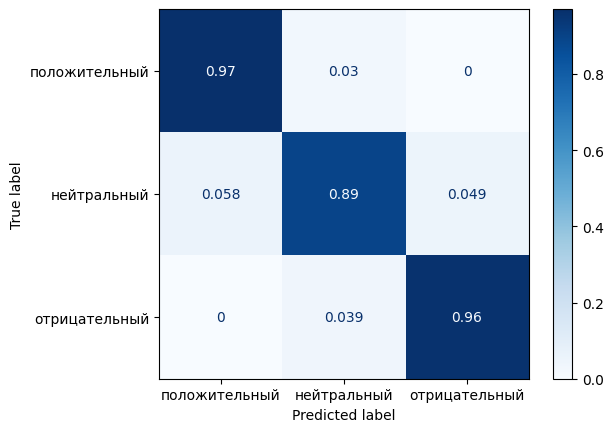

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Получение истинных меток
true_labels = dataset_test['label']
pred_labels = predictions.predictions.argmax(axis=1)

# Построение нормализованной матрицы ошибок
cm = confusion_matrix(true_labels, pred_labels, normalize='true')  # Нормализация по строкам

# Предположим, что у вас есть список меток
label_list = ['положительный', 'нейтральный', 'отрицательный']

# Отображение нормализованной матрицы ошибок
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Модель Rubеrt показала точность классификации 94% на тестовой выборке, что составило прирост эффективности +12% по сравнению с обучением на Financial Phrasebank.